In [1]:
import sys
sys.path.append('/workspaces/bha2/src')

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from connectivity_functions import *
from tree_functions import *
from ni_functions import *
from io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 25)
import seaborn as sns

In [5]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [6]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
    fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [10]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_fc, fcm_thr, scm_nonzero)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [11]:
atlas_name = "craddock_" + str(conn_size) + ".nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()

atlas_nonzero = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],1))
print(atlas_nonzero.shape)
old_rois = np.arange(1, atlas_vol.max()+1, dtype=int)
old_rois = np.delete(old_rois, zero_rows_sc)
old_rois = np.delete(old_rois, zero_rows_fc)

for idx, rois in enumerate(old_rois):
    atlas_nonzero[atlas_vol == rois] = idx+1

atlas_nonzero_img = nib.Nifti1Image(atlas_nonzero, affine=atlas.affine)

(91, 109, 91, 1)


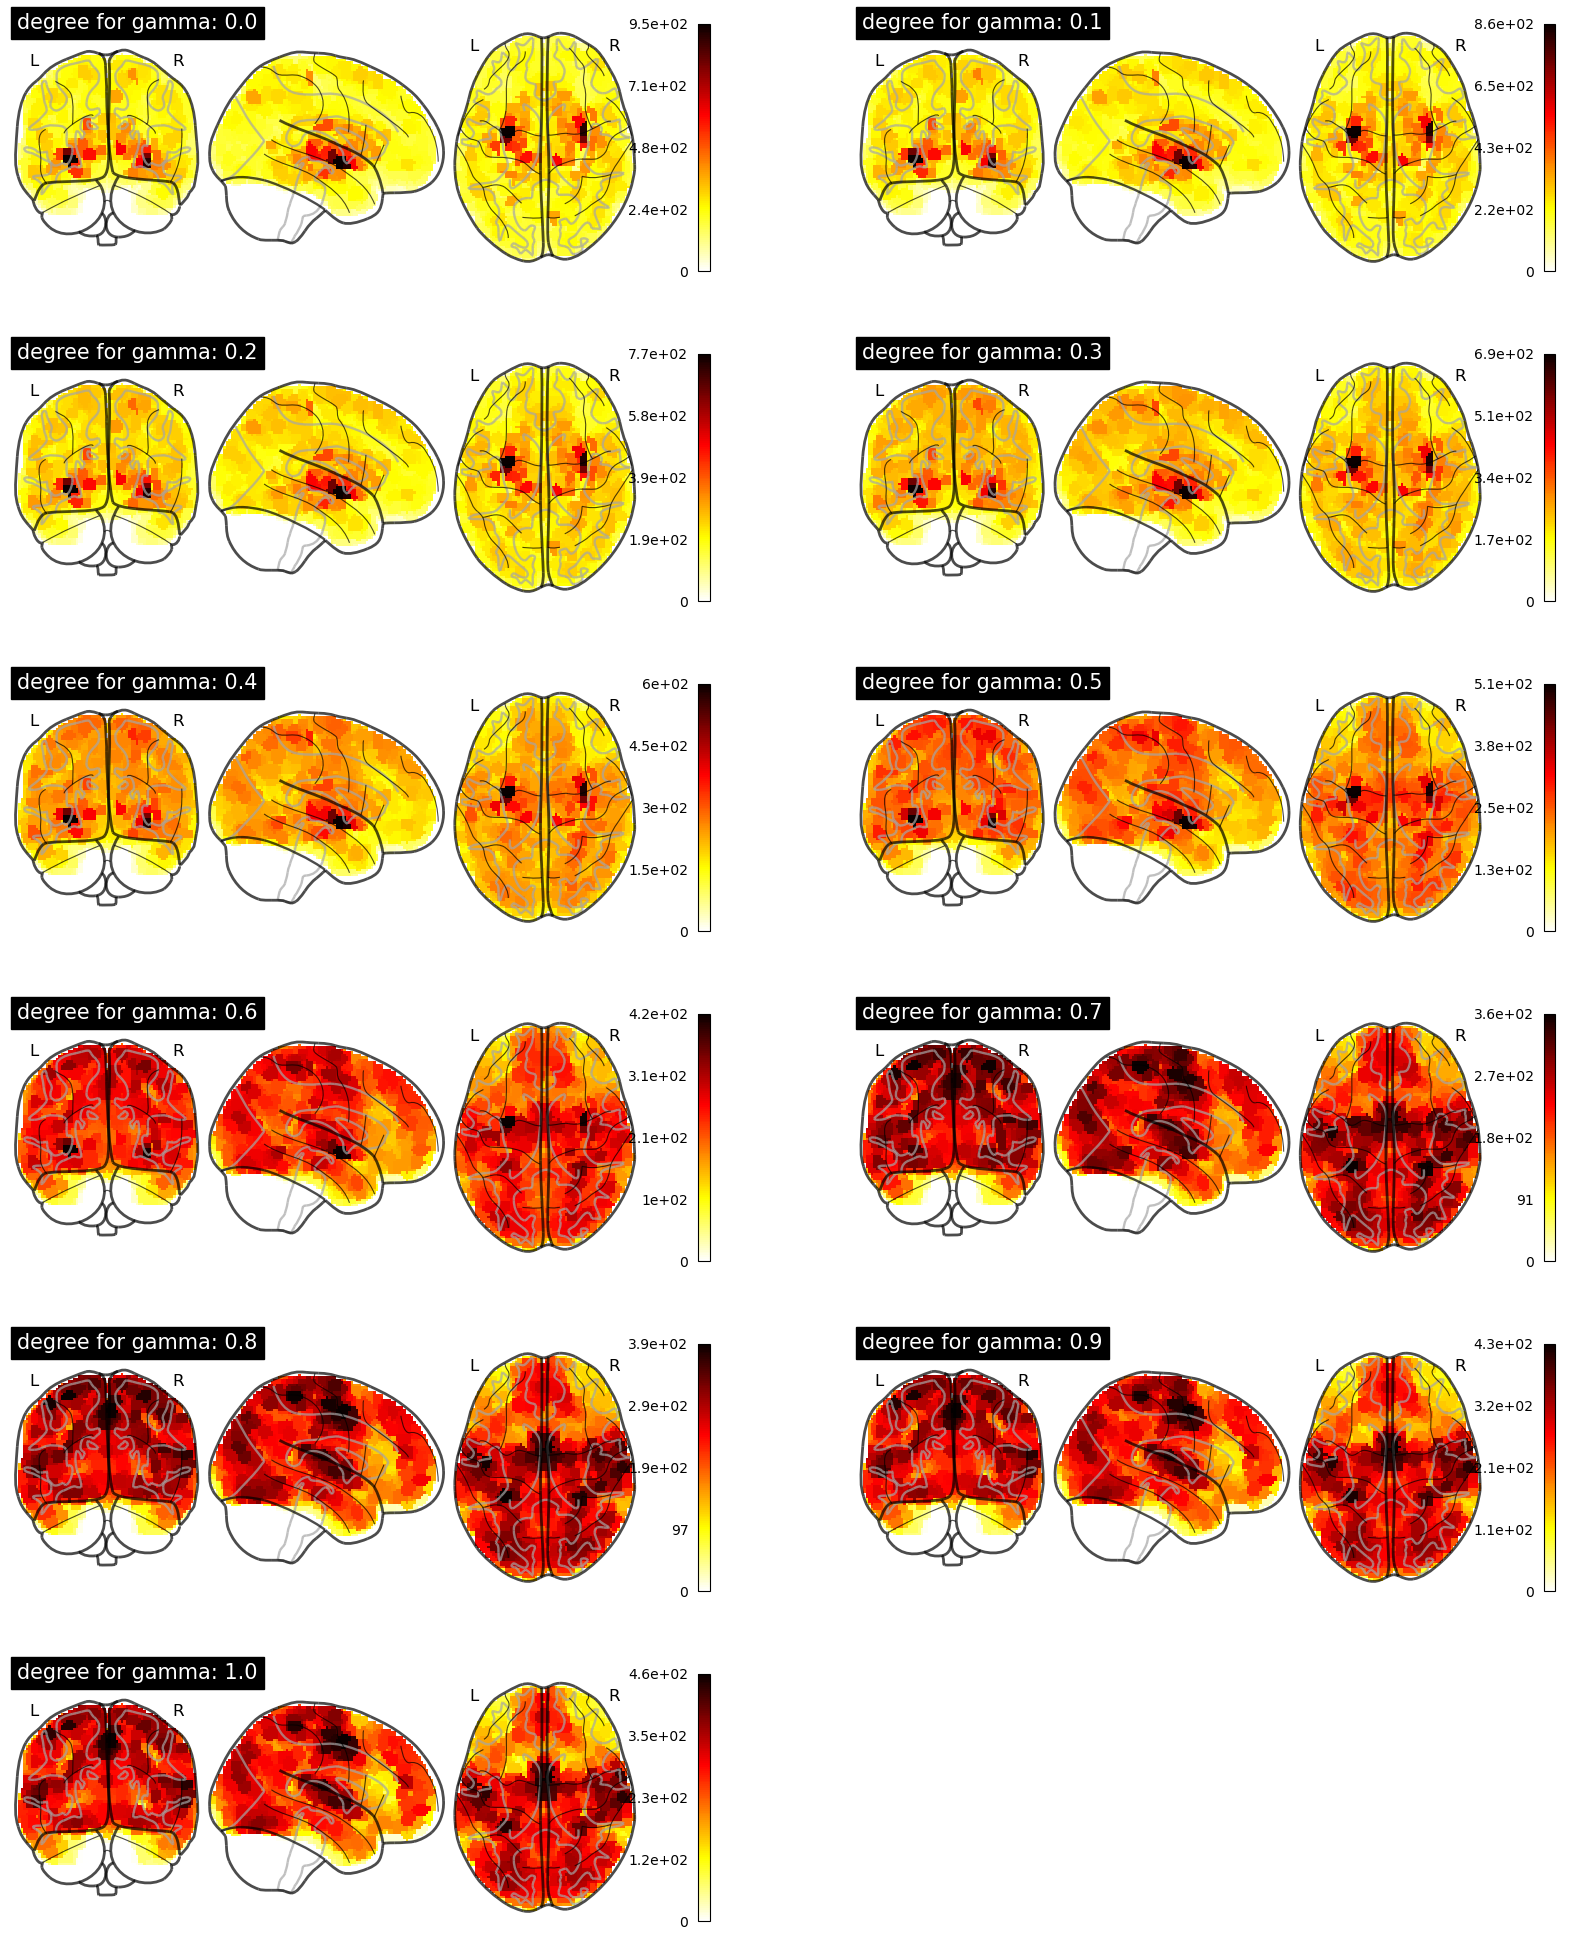

In [12]:
fig = plt.figure()

gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    
for idx,g in enumerate(gammas_vec):
    ax = fig.add_subplot(6, 2, idx+1)
    cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
    strength_fullmat = cc.sum(axis=0, dtype=float)
    deg_img = np.zeros(atlas_nonzero.shape)
    for roi in range(len(strength_fullmat)):
        deg_img[atlas_nonzero == roi+1] = strength_fullmat[roi]
    
    plotting.plot_glass_brain(nib.Nifti1Image(deg_img, affine=atlas.affine), 
        colorbar=True, title="degree for gamma: " + str(g), axes=ax)
    nib.save(nib.Nifti1Image(deg_img, affine=atlas.affine), os.path.join(project_path, "data", "results", "n" + str(conn_size), "degree_g_" + str(g) + ".nii.gz"))
    


<AxesSubplot:xlabel='area', ylabel='degree'>

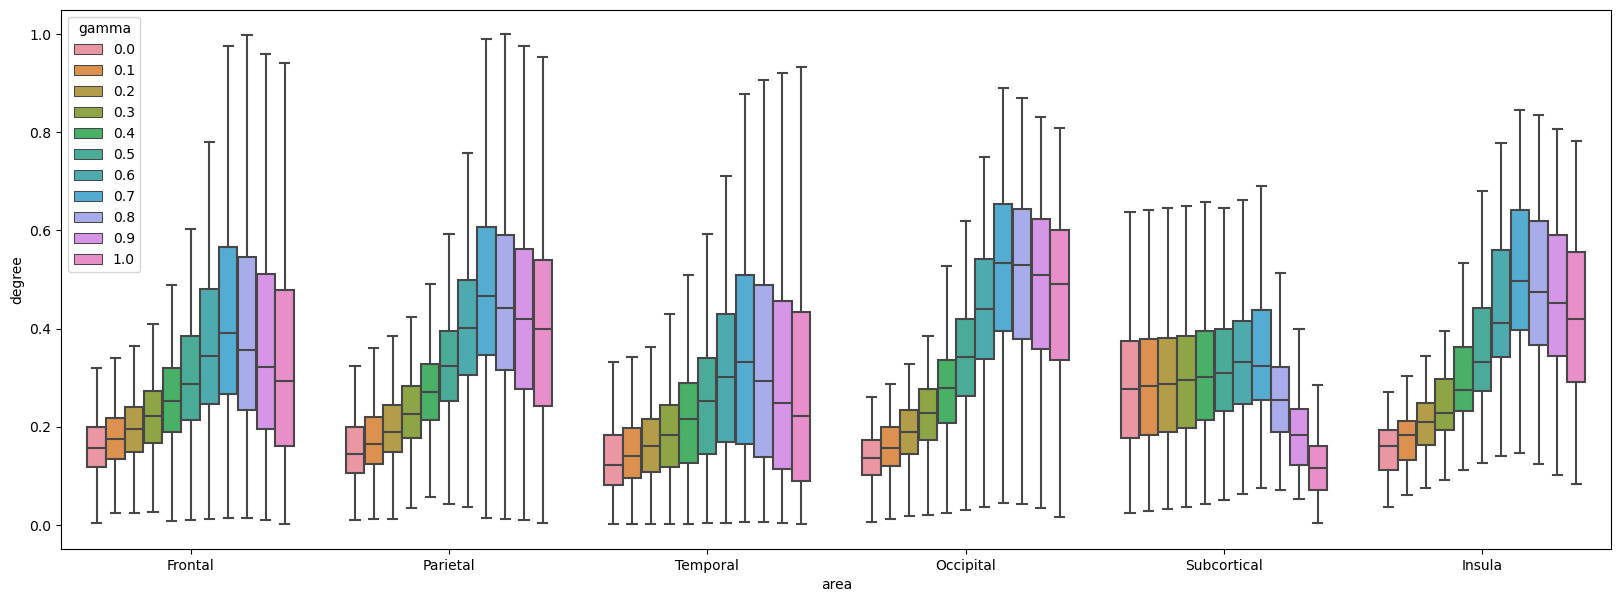

In [25]:
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]   
lobe_list = ["Frontal", "Parietal", "Temporal", "Occipital", "Subcortical", "Insula"]

strength_vals = []
area_name = []
gamma_val = []
for lobe in lobe_list:
    lobe_mask = nib.load(os.path.join(project_path, "brain_templates", "lobule_masks", lobe + "_mask.nii.gz"))
    lobe_rois = get_atlas_rois_from_mask(lobe_mask,atlas_nonzero_img)
    for g in gammas_vec:
        cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
        strength_fullmat = cc.sum(axis=0, dtype=float)
        for roi in lobe_rois:
            strength_vals.append(strength_fullmat[int(roi)-1]/np.max(strength_fullmat))
            area_name.append(lobe)
            gamma_val.append(g)

plt.rcParams['figure.figsize'] = [20, 7]
fig = plt.figure()
df = pd.DataFrame({'degree': strength_vals, 'area': area_name, 'gamma': gamma_val})
sns.boxplot(x="area", y="degree", hue="gamma", data=df, showfliers=False)